# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

# Store every image in an array

In [47]:
import os
data_dir = (r'./Training')
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
for i in categories:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))    

# Resize each image to same size for fast processing

In [48]:
img_size = 128
image_array = cv2.resize(img_array, (img_size,img_size))

In [41]:
gt1 = cv2.imread('./Training/glioma_tumor/gg (1).jpg')
mt1 = cv2.imread('./Training/meningioma_tumor/m (10).jpg')
nt1 = cv2.imread('./Training/no_tumor/1.jpg')
pt1 = cv2.imread('./Training/pituitary_tumor/p (151).jpg')

# Example of Glioma Tumor

(-0.5, 511.5, 511.5, -0.5)

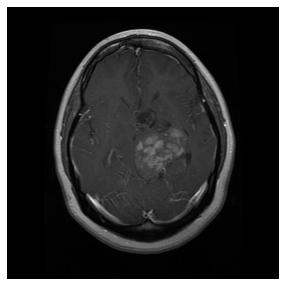

In [42]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(gt1)
plt.axis('off')

# Example of Meningioma Tumor

(-0.5, 511.5, 511.5, -0.5)

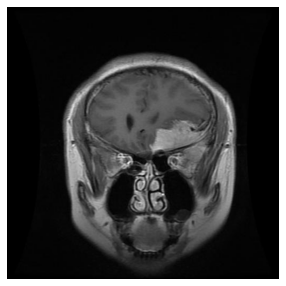

In [43]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(mt1)
plt.axis('off')

# Example of No Tumor

(-0.5, 349.5, 349.5, -0.5)

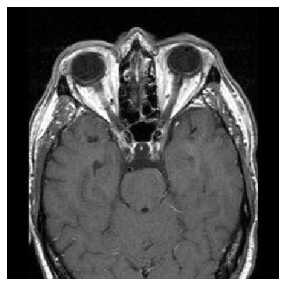

In [44]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(nt1)
plt.axis('off')

# Example of Pituitary Tumor

(-0.5, 511.5, 511.5, -0.5)

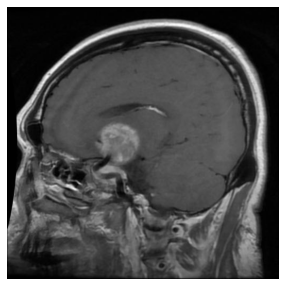

In [45]:
plt.rcParams["figure.figsize"] = (5,5)
plt.imshow(pt1)
plt.axis('off')

# Convert each image to grayscale and append into an array

In [38]:
train_data = []

for i in categories:
    train_path = os.path.join(data_dir,i)
    tag = categories.index(i)
    for img in os.listdir(train_path):
        try:
            image_arr = cv2.imread(os.path.join(train_path , img), cv2.IMREAD_GRAYSCALE)
            new_image_array = cv2.resize(image_arr, (img_size,img_size))
            train_data.append([new_image_array , tag])
        except Exception as e:
            pass

# Split the features and target in to X and y

In [10]:
X = []
y = []
for i,j in train_data:
    X.append(i)
    y.append(j)
X = np.array(X).reshape(-1,img_size,img_size)
print(X.shape)
X = X/255.0  
X = X.reshape(-1,128,128,1)

(2870, 128, 128)


# One-Hot encode the target column

In [11]:
from keras.utils.np_utils import to_categorical   

y_enc = to_categorical(y, num_classes = 4)

# Split the data into Train, Validation and Test dataset (80%-10%-10%)

In [12]:
X_train , X_test, y_train, y_test = train_test_split(X , y_enc , test_size = 0.1, random_state = 42)
X_train , X_val, y_train, y_val = train_test_split(X_train , y_train , test_size = 0.1, random_state = 42)

# Import keras' functions to create CNN model

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
#from keras.optimizers import RMSprop,Adam (if you use 2019 anaconda , please uncomment this line(remove "#") )
from tensorflow.keras.optimizers import RMSprop,Adam #(For 2020 anaconda. if you use 2019 , comment this line with "#" )
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

model = Sequential()


model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (128,128,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(4, activation = "softmax"))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 2

es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience = 3
)

batch_size = 16
imggen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0,  
        horizontal_flip=True,  
        vertical_flip=False)


# Fit the model with Train and Validation datatsets

In [14]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("models/model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

imggen.fit(X_train)
history = model.fit_generator(imggen.flow(X_train,y_train,batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              callbacks=callbacks_list)

<ipython-input-14-935cfa404f92>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(imggen.flow(X_train,y_train,batch_size = batch_size),


Epoch 1/2
145/145 [==============================] - 369s 3s/step - loss: 1.1261 - accuracy: 0.5000 - val_loss: 0.9856 - val_accuracy: 0.5290
Epoch 2/2
145/145 [==============================] - 358s 2s/step - loss: 0.8488 - accuracy: 0.6425 - val_loss: 0.8738 - val_accuracy: 0.5714


In [29]:
# serialize model structure to JSON
model_json = model.to_json()
with open(r"./models/model.json", "w") as json_file:
    json_file.write(model_json)

# Test Dataset

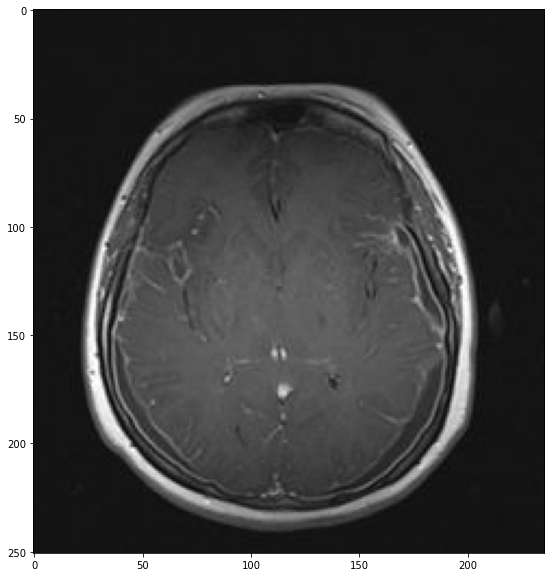

[[[19 19 19]
  [19 19 19]
  [19 19 19]
  ...
  [19 19 19]
  [19 19 19]
  [19 19 19]]

 [[19 19 19]
  [19 19 19]
  [19 19 19]
  ...
  [19 19 19]
  [19 19 19]
  [19 19 19]]

 [[19 19 19]
  [19 19 19]
  [19 19 19]
  ...
  [19 19 19]
  [19 19 19]
  [19 19 19]]

 ...

 [[19 19 19]
  [19 19 19]
  [19 19 19]
  ...
  [19 19 19]
  [19 19 19]
  [19 19 19]]

 [[19 19 19]
  [19 19 19]
  [19 19 19]
  ...
  [19 19 19]
  [19 19 19]
  [19 19 19]]

 [[19 19 19]
  [19 19 19]
  [19 19 19]
  ...
  [19 19 19]
  [19 19 19]
  [19 19 19]]]
[[[[19 19 19]
   [19 19 19]
   [19 19 19]
   ...
   [19 19 19]
   [19 19 19]
   [19 19 19]]

  [[19 19 19]
   [19 19 19]
   [19 19 19]
   ...
   [19 19 19]
   [19 19 19]
   [19 19 19]]

  [[19 19 19]
   [19 19 19]
   [19 19 19]
   ...
   [19 19 19]
   [19 19 19]
   [19 19 19]]

  ...

  [[19 19 19]
   [19 19 19]
   [19 19 19]
   ...
   [19 19 19]
   [19 19 19]
   [19 19 19]]

  [[19 19 19]
   [19 19 19]
   [19 19 19]
   ...
   [19 19 19]
   [19 19 19]
   [19 19 19]]

  [[19

In [27]:
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.models import load_model
#saved_model = load_model(r"C:/Users/gts/jupiter python/Brain-Tumor-Classification/models/model_final.h5")
saved_model = load_model(r"./models/model_final.h5")
status = True


import os
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
#test_data_dir = r'C:/Users/gts/jupiter python/Brain Tumor Classification/M2/Training/no_tumor'
test_data_dir = r'./Training/no_tumor'
img=load_img(test_data_dir+"//"+'image(25).jpg')
plt.imshow(img)
plt.show()

img = np.asarray(img)
print(img)

img = np.expand_dims(img, axis=0)
print(img)

images=np.vstack([img])
    
    
images.resize(1,150,150,3)
print(images.shape)


val=saved_model.predict(images)
print(val.round())   
